# NI-VSM 1.DÚ
---
Jan Peřina  & Zdena Tropková & Matěj Hoffman

---

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from IPython.display import HTML, display
pd.options.plotting.backend = "plotly"
pd.options.display.max_columns = 30

In [2]:
K = 30
L = len("Perina")
X = 1 + (K*L*23 % 20)
Y = (X + ((K*5 + L*7) % 19) % 20) + 1
xxx = f'{X:03d}.txt'
yyy = f'{Y:03d}.txt'
print(f"Budou použity soubory {xxx} a {yyy}")

Budou použity soubory 001.txt a 004.txt


## Načtení souborů

In [3]:
with open(f'./data/{xxx}', 'r') as f:
    f.readline()  # nadpis ignorujeme
    first = f.read()
    print(f'Délka prvního textu: {len(first)}')

with open(f'./data/{yyy}', 'r') as f:
    f.readline()
    second = f.read()
    print(f'Délka druhého textu: {len(second)}')

Délka prvního textu: 6458
Délka druhého textu: 5607


## Spočtení pravděpodobností

Pravděpodobnost spočteme jako počet výskytů daného znaku v textu děleno počtem znaků v textu, tedy jeho délky.

$$ \text{p}(x,t)= \frac{\# \text{ výskytů znaku }x\text{ v textu }t}{\# \text{ znaku v textu }t} $$

In [4]:
def count(text):
    counts = {}

    for x in text:
        if x not in counts:
            counts[x] = 1
        else:
            counts[x] += 1

    df = pd.DataFrame.from_dict(counts, orient='index', columns=['counts'])
    df['freq'] = df['counts'] / len(text)
    df.sort_values(by=['freq'], ascending=False, inplace=True)
    df.index = df.index.rename('znak')

    return df

In [30]:
# první text
df_first = count(first)
print(df_first[['counts']].T)

znak            e    a    t    o    n    r    h    d    i    s    l    u    g  \
counts  1199  659  438  436  399  355  350  337  303  297  291  249  159  141   

znak      f    w    m    c   b   p   y   k   v   j  q  z  x  
counts  137  117  109  102  96  91  83  52  30  15  6  6  1  


In [29]:
# druhý text
df_second = count(second)
print(df_second[['counts']].T)

znak            e    t    a    o    h    n    i    r    s    d    l    u    f  \
counts  1029  577  409  384  355  316  310  307  295  284  209  173  129  129   

znak      c    w   g   m   p   y   b   v   k   j  q  z  x  
counts  124  117  94  80  72  60  55  37  30  13  8  7  4  


## Vizualizace pravděpodobností

Jednotlivé pravděpodobnosti nyní zobrazíme pomocí sloupcového grafu, osa y reprezentuje pravděpodobnost znaku v textu. Osa X je diskrétní a reprezentuje jednotlivé znaky seřazené od nejčetnějšího po ten nejméně četný.

In [7]:
df_first['freq'].rename('Pravděpodobnost').plot(
    kind='bar', title="Pravděpodobnosti znaků v prvním textu", labels={'value': 'hodnota'})

Jak je vidět, tak znakem s největší pravděpodobností je mezera, následně znaky `e`, `a` a `t`. Nejméně pravděpodobné naopak byly znaky `q`, `z` a `x`.

Obdobně jsme zvizualizovali hodnoty pro druhý text.

In [8]:
df_second['freq'].rename('Pravděpodobnost').plot(
    kind='bar', title="Pravděpodobnosti znaků v druhém textu", labels={'value': 'hodnota'})

Z grafu je vidět, že opět byla nejčastější mezera, hned po ní opět trojice `e`, `a`, `t` (v jiném pořadí) a nejméně četné byly opět znaky `q`,`z` a `x`.

Na základě této podobnosti jsme se rozhodli vykreslit graf pravděpodobností jednotlivých znaků pro oba texty. 

In [9]:
c = df_first[['freq']].join(df_second[['freq']], lsuffix='_f', rsuffix='_s')
c.columns = ['První text', 'Druhý text']
c.plot(kind='bar', barmode='group', title='Srovnání pravděpodobností ',
       labels={'value': 'pravděpodobnost'})

Jak je vidět z grafu, sloupce pro oba texty jsou s menšími rozdíly velmi podobné. Rozhodli jsme se proto tedy spočíst korelaci mezi pravděpodobnostmi jednotlivých znaků.

#### Korelace pravděpodobností

In [10]:
df_first[['freq']].join(df_second[['freq']], lsuffix='_f', rsuffix='_s').corr().iloc[1, 0]

0.9945439587726614

Jak je vidět, tak pravděpodobnosti výskytů jednotlivých znaků v techtech je silně korelovaná.

## Entropie

Dalším úkolem bylo spočítat entropii pro jednotlivé texty.

Entropie se počítá jakožto:

$$ H(x) = -\sum_{i=1}^n p(x_i) \log_2 p(x_i),$$

kde  $p_i$ značí pravděpodobnost znaku $i$.

In [11]:
def entropy(p):
    return - (p* p.apply(np.log2)).sum()

In [12]:
print(f'Entropie prvního textu: {entropy(df_first["freq"])}')

Entropie prvního textu: 4.094689728708522


In [13]:
print(f'Entropie druhého textu: {entropy(df_second["freq"])}')

Entropie druhého textu: 4.078928812189477


Z hodnot je vidět, že znaky v prvním textu nesou větší míru informace, avšak k rozdílu dochází až v řádu setin.

## Optimální instantní binární kód 


Dalším úkolem vylo vygenerovat optimální instantní binární kód pro první text. 

Z definice víme, že Huffmanovo kódóvání vyprodukuje optimální binární kód pro předem zadaný text.

Huffmanovo kódování funguje na principu hladového algoritmu, kde je každému znaku přiřazen jeden vrchol v grafu. Následně algoritmus slučuje $d$ nejméně pravděpodobných hodnot pod nový vrchol s pravděpodobností rovnou součtu pravděpodobností úzlů a každé hraně přiřadí znakem z $D$-nární abecedy. Takto pokračuje, dokud mu nezůstane pouze jeden vrchol - kořen $d$-nárního stromu, na základě kterého můžeme jednotlivé znaky kódovat. 

Tímto dojde k efektivnímu rozložení délky kódových slov tak, že málo pravděpodobnéjším znakům udou odpovídat delší kódová slova a těm pravděpodobnějším kratší.


In [14]:
class Node:
    '''
    Pomocná třída pro reprezentaci kódovacího stromu
    '''
    def __init__(self, value, frequency):
        self.left = None
        self.right = None
        self.value = value
        self.frequency = frequency

    @property
    def is_leaf(self):
        return self.right is None and self.left is None

    def __repr__(self):
        return f'<\'{self.value}\', p={self.frequency}>'

In [15]:
def huffman(freq):
    '''
    Huffmanův kód sestaví dekódovací strom a z něj kódovací tabulku

    parametr: slovník k=znak, v=pravdepodobnost
    '''
    nodes = [Node(char, freq) for (char, freq) in freq.iteritems()]  # vytvoří listy pro jednotlivé znaky
    while len(nodes) > 1: # hladově spojuje 2 vrcholy
        nodes = sorted(nodes, key=lambda x: x.frequency, reverse=False)
        x, y = nodes[:2]
        new_node = Node('', x.frequency + y.frequency)
        new_node.left = x
        new_node.right = y
        nodes = nodes[2:] + [new_node]

    def C(code, direction): return f'{code}{int(direction)}'
    root = nodes[0]

    def get_table(root, code):

        if root.is_leaf:
            return {root.value: code}
        
        l = get_table(root.left, C(code, False))
        r = get_table(root.right, C(code, True))
        return l | r

    return root, get_table(root, '')

In [16]:
root, table = huffman(df_first.freq)

## Optimální binární instantní kód 

Výše zmíněným algoritmem jsme dostali následující kód.

In [17]:
_table = pd.DataFrame(columns=table.keys(), data=[table.values()], index=[0]).T
_table.index = _table.index.rename('Znak')
_table.columns = ['binární kód'] 
display(HTML(_table.to_html()))

,binární kód
Znak,
i,0000
g,00010
u,00011
d,0010
h,0011
e,010
r,0110
n,0111
y,100000


Z tabulky je vidět, že četnější znaky mají opravdu kratší kódová slova (a obráceně). 

Jenom pro zkouškua demonstraci jsme zakódovali a následně dekódovali zřetězené unikátní znaky z prvnvího textu.

In [18]:
def encode(code, string):
    return ''.join([code[char] for char in string])

In [19]:
def decode(node, code):
    if not code:
        return node.value

    if node.is_leaf:
        rest = decode(root, code) if code else ''
        return node.value + rest

    return decode(node.right if code[0] == '1' else node.left, code[1:])

In [20]:
encode(table, ''.join(df_first.index))

'111010101110101001011101100011001000001101111001000110001011010111010011000010001110001010000110000011000101100011111000110111000110011110001100011000110010'

In [21]:
decode(root, '111010101110101001011101100011001000001101111001000110001011010111010011000010001110001010000110000011000101100011111000110111000110011110001100011000110010')

' eatonrhdislugfwmcbpykvjqzx'

Je vidět, že opravdu funguje.

# Střední délka kódu

Střední délku kódu spočítáme jako

$$ L(C) = \sum_{i=1}^n p(x_i) l(x_i)$$
 
kde $ p(x_i)$ je pravděpodobnost daného znaku a $l(x_i)$ je délka kódového slova.

In [22]:
def mean_length(table, freq):
    return sum(p * len(table[i]) for i, p in freq.iteritems())

In [23]:
l_f = mean_length(table, df_first.freq)
print(f'Střední délka kódu C pro první text: {l_f}')

Střední délka kódu C pro první text: 4.137503871167543


In [24]:
l_s = mean_length(table, df_second.freq)
print(f'Střední délka kódu C pro druhý text: {l_s}')

Střední délka kódu C pro druhý text: 4.1385767790262165


## Ověření optimality kódu

Z definice Huffmanovo kódování produkuje optimální instantní kód. Na základě ukázky výše se to zdá být pravda.

Abychom si však jisti ověříme, že: 

$$H_D(X) \leq L \le H_D(X) + 1$$

kde $H_D$ značí entropii a $L$ střední délku kódového slova z textu $t_i$.

Ve volném slova smyslu bychom tuto podmínku mohli interpretovat tak, že v teoretickém případě nám postačí $H_D$ bitů pro zakódování textu, ale jelikož potřebujeme zachovat nesingularitu kódu, můžeme vygenerovat kód, který bude od teoretického optima horší, avšak ne více než o jeden bit. 

Pro kontrolu jsme vykreslili interval možných řešení, který je zprava otevřený.

 Střední délce kódu odpovídá modrý bod. 

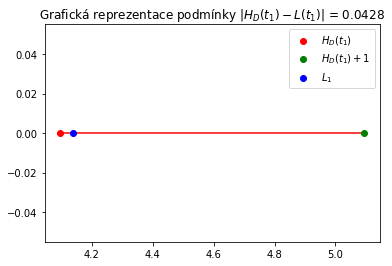

In [25]:
fig = plt.figure()
plt.plot([entropy(df_first.freq), entropy(df_first.freq)+1], [0, 0], 'r')
plt.scatter([entropy(df_first.freq)], [0], c='r', label='$H_D({t_1})$')
plt.scatter([entropy(df_first.freq) + 1], [0], c='g', label='$H_D({t_1}) + 1$', zorder=4)
plt.scatter(l_f, 0, c='b', zorder=5, label='$L_1$')
plt.legend()
plt.title(f'Grafická reprezentace podmínky $|H_D(t_1) - L(t_1)|$ = {abs(l_f - entropy(df_first.freq)):.4f}')

plt.show()

Z grafu je vidět, že daný instantní kód pro první text je opravdu optimální.

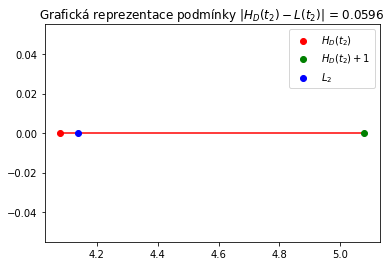

In [26]:
fig = plt.figure()
plt.plot([entropy(df_second.freq), entropy(df_second.freq)+1], [0, 0], 'r')
plt.scatter([entropy(df_second.freq)], [0], c='r', label='$H_D({t_2})$')
plt.scatter([entropy(df_second.freq) + 1], [0], c='g', label='$H_D({t_2}) + 1$', zorder=4)
plt.scatter(l_s, 0, c='b', zorder=5, label='$L_2$')
plt.legend()
plt.title(f'Grafická reprezentace podmínky $|H_D(t_2) - L(t_2)|$ = {abs(l_s - entropy(df_second.freq)):.4f}')

plt.show()

Z druhého grafu je vidět, že střední délka kódóvého slova druhého textu splňuje podmínku i pro druhý text, avšak vzdálenost od spodní hranice, tedy entropie textu je v tomto případě větší, tudiž je vzdálenější od teoretického optima větší, než pro první text.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=12755e79-5e62-420e-8562-383193a592cf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>